In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

from datetime import datetime

# **Preprocessing**

In [60]:
# Step 0 : filter on small caps and micro caps
#def filter_data(df, small_cap_value=1, micro_cap_value=1):
#    """Filters rows based on small_cap and micro_cap values and returns a copy of the filtered DataFrame."""
#    filtered_df = df[(df['small_cap'] == small_cap_value) & (df['micro_cap'] == micro_cap_value)].copy()
#    return filtered_df

In [61]:
# Step 1 : target creation + train_test_split
# Creating target variables to automate creation of quarterly, yearly and 2-yearly targets, because well, DON'T REPEAT YOURSELF!
def create_target_variable(df, frequency:int, threshold):
    if frequency == 1:
        col = 'mc_qtr_growth_pct'
    if frequency == 4:
        col = 'mc_yr_growth_pct'
    if frequency == 8:
        col = 'mc_2yr_growth_pct'
   #else:
   #    raise ValueError("Invalid frequency. Use 1 (quarterly), 4 (yearly), or 8 (2-year).")
    df[col] = df[col].shift(-frequency)
    df.dropna(subset=col, inplace=True)
    target_func = lambda x: 1 if ((x[col] > threshold) & (x.small_cap == 1)) else 0
    df['target'] = df.apply(target_func, axis=1)
    return df

In [62]:
#def drop_columns(df, cols_to_drop=None):
#    """Drops specified columns from the DataFrame."""
#
#    if cols_to_drop is None:
#       # Default columns to drop if none are specified
#        cols_to_drop = ['cik', 'CIK', 'date', 'stprba', 'quarter', 'year']
#    return df.drop(cols_to_drop, axis=1, errors='ignore')


In [63]:
# Creating a custom function for the group split
def group_train_test_split(data, test_size=0.2, random_state=None):

    data['qtr'] = data.quarter.apply(lambda x : x.split('-')[1])


    # We split by groups (company ticker) while keeping the data structure intact.
    unique_groups = data['TICKER'].unique()
    train_groups, test_groups = train_test_split(unique_groups, test_size=test_size, random_state=random_state)

    # Split into train and test sets
    X_train = data[data['TICKER'].isin(train_groups)]
    X_test = data[data['TICKER'].isin(test_groups)]

    # Define columns to drop: Ticker, cik, date, quarter, year + growth columns
    cols_to_drop = ['mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct', 'target']

    # Drop unwanted columns
    X_train = X_train.drop(cols_to_drop + ['cik', 'CIK', 'date', 'stprba', 'quarter', 'year', 'TICKER'], axis=1, errors='ignore')
    X_test = X_test.drop(cols_to_drop + ['cik', 'CIK', 'date', 'stprba', 'quarter', 'year', 'TICKER'], axis=1, errors='ignore')

    # Extract the target variable from the dataset
    y_train = data[data['TICKER'].isin(train_groups)]['target']
    y_test = data[data['TICKER'].isin(test_groups)]['target']

    return X_train, X_test, y_train, y_test


In [64]:
# Step 2: Identify numerical and categorical features
def identify_feature_types(df):
    """Identifies the numerical and categorical columns in the DataFrame."""
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Exclude 'Ticker' from categorical features as it's not needed for transformation
    if 'TICKER' in categorical_features:
        categorical_features.remove('TICKER')

    return numerical_features, categorical_features

In [65]:
# Step 3: Create preprocessing pipeline for numerical and categorical features
def create_preprocessing_pipeline(numerical_features, categorical_features):
    """Creates the preprocessing pipeline for numerical and categorical features."""
    # Preprocessing for numerical data: RobustScaler to make our numbers más robusto.
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle NaNs
        ('scaler', RobustScaler())
        #('scaler', MinMaxScaler()) # Scale the data
    ])

    # Preprocessing for categorical data: OneHotEncoder to give each category its own columm...
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categories
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categories
    ])

    # Combine the transformers into one big ColumnTransformer.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor


# Function to save the preprocessor
def save_preprocessor(preprocessor, file_path='~/models/'):
    """Saves the preproc with a timestamp."""
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    preproc_filename = f'preprocessor_{timestamp}.pkl'
    # Ensure model directory exists
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    file_path = os.path.join(file_path, preproc_filename   )
    with open(file_path, 'wb') as file:
        pickle.dump(preprocessor, file)

    print(f"Preprocessor saved to {file_path}")

In [66]:
# Step 4: Function to preprocess data in training mode (fitting the pipeline)
def preprocess_training_data(X_train):
    """Fits and transforms the training data using the provided pipeline."""
    # Identify feature types
    numerical_features, categorical_features = identify_feature_types(X_train)
    preprocessor = create_preprocessing_pipeline(numerical_features, categorical_features)

    # Fit and transform the training data
    X_train_processed = preprocessor.fit_transform(X_train)

        # Save the preprocessor after fitting
    save_preprocessor(preprocessor)

    return X_train_processed, preprocessor

In [67]:
# Step 5: Function to preprocess new/unseen/test data in production mode (only transforming)
def preprocess_new_data(X_new, preprocessor):
    """Transforms new/unseen/test data using a pre-fitted pipeline."""
    if preprocessor is None:
        raise ValueError("The preprocessor must be fitted on training data first before transforming new data.")

    # Transform the new data (no fitting here)
    X_new_processed = preprocessor.transform(X_new)
    return X_new_processed

# **Training**

In [68]:
def save_model(model, model_type, model_dir='~/models/'):
    """Saves the trained model with a timestamp."""
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_filename = f'{model_type}_{timestamp}.pkl'

    # Ensure model directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the trained model
    model_path = os.path.join(model_dir, model_filename)
    with open(model_path, 'wb') as f_model:
        pickle.dump(model, f_model)

    print(f"Model saved to: {model_path}")
    return model_path

def evaluate_model(model, X_train, y_train, X_test, y_test, scoring_metrics=['accuracy', 'precision', 'recall', 'f1']):
    """Evaluates the model with cross-validation and test set metrics."""
    cv_metrics = {}
    for metric in scoring_metrics:
        with tqdm(total=5, desc=f"Cross-Validation ({metric})", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
            cv_metrics[metric] = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
            pbar.update(5)

    print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics[m].mean():.4f}' for m in cv_metrics])}")

    # Test on the test set
    y_pred_test = model.predict(X_test)

    # Calculate test set metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test)
    }

    # Combine cross-validated and test metrics
    metrics = {**{f'cv_{m}': cv_metrics[m].mean() for m in cv_metrics}, **test_metrics}
    return metrics

def train_logistic_regression_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates a logistic regression model, saves the trained model, and returns evaluation metrics."""

    model_type = 'logistic_regression'
    model = LogisticRegression(C=0.001, max_iter=2000, solver='lbfgs')

    # Train model with a progress bar
    with tqdm(total=100, desc=f"Training {model_type}", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        model.fit(X_train, y_train)
        pbar.update(100)

    # Check number of iterations
    print(f"Number of iterations: {model.n_iter_}")

    # Evaluate the model
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(model, model_type, model_dir)

    return metrics, model

def train_knn_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates a K-Nearest Neighbors model, saves the trained model, and returns evaluation metrics."""

    model_type = 'knn'
    knn = KNeighborsClassifier()

    # Train model with a progress bar
    with tqdm(total=100, desc=f"Training {model_type}", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        knn.fit(X_train, y_train)
        pbar.update(100)

    # Evaluate the model
    metrics = evaluate_model(knn, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(knn, model_type, model_dir)

    return metrics, knn

def train_svc_rbf_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates an SVM with RBF kernel, saves the trained model, and returns evaluation metrics."""

    model_type = 'svc_rbf'
    svc_rbf = SVC(kernel='rbf', probability=True)  # Set `probability=True` for log_loss and cross-validation

    # Train model with a progress bar
    #with tqdm(total=100, desc=f"Training {model_type}", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
    svc_rbf.fit(X_train, y_train)
        #pbar.update(100)

    # Evaluate the model
    metrics = evaluate_model(svc_rbf, X_train, y_train, X_test, y_test)

    # Save the model
    save_model(svc_rbf, model_type, model_dir)

    return metrics, svc_rbf

In [69]:
'''# Step 6: Function to train logistic regression, evaluate, and save the model
def train_logistic_regression_and_save(X_train, y_train, X_test, y_test, model_dir='~/models/'):
    """Trains, evaluates a logistic regression model, saves the trained model with a timestamp and returns evaluation metrics."""

    # Step 1: Train logistic regression model with a progress bar
    logistic_model = LogisticRegression(solver='saga', max_iter=2000)
    with tqdm(total=100, desc="Training Logistic Regression", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        logistic_model.fit(X_train, y_train)
        pbar.update(100)

    # Check number of iterations
    print(f"Number of iterations: {logistic_model.n_iter_}")

    # Step 2: Evaluate using cross-validation for accuracy, precision, recall, and F1-score
    cv_metrics = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        with tqdm(total=5, desc=f"Cross-Validation ({metric})", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
            cv_metrics[metric] = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring=metric)
            pbar.update(5)

    print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics[m].mean():.4f}' for m in cv_metrics])}")

    # Step 3: Test on the test set
    y_pred_test = logistic_model.predict(X_test)

    # Calculate test set metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test)
    }

    # Combine cross-validated and test metrics into a single dictionary
    metrics = {**{f'cv_{m}': cv_metrics[m].mean() for m in cv_metrics}, **test_metrics}

    # Step 4: Save the model with timestamp and type
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_filename = f'logistic_regression_{timestamp}.pkl'

    # Ensure model directory exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the trained model
    model_path = os.path.join(model_dir, model_filename)
    with open(model_path, 'wb') as f_model:
        pickle.dump(logistic_model, f_model)

    print(f"Model saved to: {model_path}")

    return metrics, logistic_model'''

'# Step 6: Function to train logistic regression, evaluate, and save the model\ndef train_logistic_regression_and_save(X_train, y_train, X_test, y_test, model_dir=\'~/models/\'):\n    """Trains, evaluates a logistic regression model, saves the trained model with a timestamp and returns evaluation metrics."""\n\n    # Step 1: Train logistic regression model with a progress bar\n    logistic_model = LogisticRegression(solver=\'saga\', max_iter=2000)\n    with tqdm(total=100, desc="Training Logistic Regression", bar_format=\'{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]\') as pbar:\n        logistic_model.fit(X_train, y_train)\n        pbar.update(100)\n\n    # Check number of iterations\n    print(f"Number of iterations: {logistic_model.n_iter_}")\n\n    # Step 2: Evaluate using cross-validation for accuracy, precision, recall, and F1-score\n    cv_metrics = {}\n    for metric in [\'accuracy\', \'precision\', \'recall\', \'f1\']:\n        with tqdm(total=5, desc=f"Cross-Validation 

# Grid search

In [70]:
def run_grid_search(X_train, y_train):
    """Runs a grid search on logistic regression model to find the best hyperparameters."""

    # Define the parameter grid for Logistic Regression
    param_grid = {
        'solver': ['saga', 'lbfgs'],  # Different solvers
        'max_iter': [1500, 2000, 2500],  # Number of iterations
        'C': [0.005, 0.007, 0.01, 0.12, 0.15]  # Regularization strength
    }

    # Create a Logistic Regression model
    logistic_model = LogisticRegression()

    # Set up the GridSearchCV
    grid_search = GridSearchCV(
        estimator=logistic_model,
        param_grid=param_grid,
        scoring='precision',  # Choose appropriate scoring metric
        cv=5,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=1  # Verbosity level
    )

    # Fit Grid Search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

In [106]:
def knn_run_grid_search(X_train, y_train):
    """Runs a grid search on knn model to find the best hyperparameters."""

    # Define the parameter grid for Logistic Regression
    param_grid = {
        'n_neighbors': [550],  # Different solvers
        #'max_iter': [1500, 2000, 2500],  # Number of iterations
        #'C': [0.005, 0.007, 0.01, 0.12, 0.15]  # Regularization strength
    }

    # Create a Logistic Regression model
    knn_model = KNeighborsClassifier()

    # Set up the GridSearchCV
    grid_search = GridSearchCV(
        estimator=knn_model,
        param_grid=param_grid,
        scoring='precision',  # Choose appropriate scoring metric
        cv=3,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=1  # Verbosity level
    )

    # Fit Grid Search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

In [113]:
def run_xgboost(X_train, y_train):
    """Runs a grid search on knn model to find the best hyperparameters."""

    # Define the parameter grid for Logistic Regression
    param_grid = param_grid = {'n_estimators': [200],
                               'learning_rate': [0.01],
                               'max_depth': [5]}

#{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

    # Create a Logistic Regression model
    model = XGBClassifier()

    # Set up the search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='precision',  # Choose appropriate scoring metric
        cv=3,  # Number of cross-validation folds
        n_jobs=-1,  # Use all available cores
        verbose=1  # Verbosity level
    )

    # Fit Grid Search
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

# **Running the functions on the dataset**

In [72]:

# preprocessor import create_target_variable, group_train_test_split, identify_feature_types, create_preprocessing_pipeline,preprocess_training_data, preprocess_new_data,train_logistic_regression, filter_data


df = pd.read_csv('~/Small-Cap-Scout/raw_data/data_for_preprocessing.csv', index_col=[0])


In [73]:
df.head()

,cik,date,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,...,TICKER,market_cap,mc_qtr_growth,mc_qtr_growth_pct,mc_yr_growth,mc_yr_growth_pct,mc_2yr_growth,mc_2yr_growth_pct,small_cap,micro_cap
0,1750,2011-02-28,1.655991e+09,9.278390e+08,54716000.0,409295000.0,8.513950e+08,419182000.0,432213000.0,804596000.0,...,AIR,1045.889727,46.783392,0.046825,77.281557,0.079786,NaN,NaN,1,0
1,1750,2011-05-31,1.703727e+09,9.139850e+08,57433000.0,465365000.0,8.684380e+08,416010000.0,452428000.0,835289000.0,...,AIR,1024.472219,-21.417508,-0.020478,306.796787,0.427487,NaN,NaN,1,0
2,1750,2011-08-31,1.752372e+09,9.442470e+08,35523000.0,472856000.0,9.032430e+08,350085000.0,553158000.0,849129000.0,...,AIR,882.619592,-141.852627,-0.138464,255.395538,0.407184,NaN,NaN,1,0
3,1750,2011-11-30,1.821612e+09,9.550530e+08,27870000.0,521431000.0,9.582200e+08,374944000.0,583276000.0,863392000.0,...,AIR,727.886752,-154.732840,-0.175311,-271.219583,-0.271462,NaN,NaN,1,0
4,1750,2012-02-29,2.220293e+09,1.065389e+09,59294000.0,797765000.0,1.328974e+09,560986000.0,767988000.0,891319000.0,...,AIR,899.522315,171.635564,0.235800,-146.367411,-0.139945,-69.085854,-0.071325,1,0


In [74]:
df.columns

Index(['cik', 'date', 'Assets', 'AssetsCurrent', 'Cash', 'AssetsNoncurrent',
       'Liabilities', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent', 'Equity',
       'HolderEquity', 'RetainedEarnings', 'AdditionalPaidInCapital',
       'TreasuryStockValue', 'TemporaryEquity', 'RedeemableEquity',
       'LiabilitiesAndEquity', 'Revenues', 'CostOfRevenue', 'GrossProfit',
       'OperatingExpenses', 'OperatingIncomeLoss',
       'IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit',
       'AllIncomeTaxExpenseBenefit', 'IncomeLossFromContinuingOperations',
       'IncomeLossFromDiscontinuedOperationsNetOfTax', 'ProfitLoss',
       'NetIncomeLossAttributableToNoncontrollingInterest', 'NetIncomeLoss',
       'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInOperatingActivities',
       'NetCa

In [75]:
# Step 2: Drop unwanted columns before target creation
#df_cleaned = drop_columns(df, cols_to_drop=['cik', 'CIK', 'date', 'stprba', 'quarter', 'year', ])

In [76]:
#df_cleaned.columns

In [77]:
# Step 3: Create target variables and split the data
df_qtr = create_target_variable(df, frequency=1, threshold=0.5)
df_yr = create_target_variable(df, frequency=4, threshold=0.5)
df_2yr = create_target_variable(df, frequency=8, threshold=0.5)

In [78]:
X_train_qtr, X_test_qtr, y_train_qtr, y_test_qtr = group_train_test_split(df_qtr)
X_train_yr, X_test_yr, y_train_yr, y_test_yr = group_train_test_split(df_yr)
X_train_2yr, X_test_2yr, y_train_2yr, y_test_2yr = group_train_test_split(df_2yr)

In [79]:
X_train_qtr.columns

Index(['Assets', 'AssetsCurrent', 'Cash', 'AssetsNoncurrent', 'Liabilities',
       'LiabilitiesCurrent', 'LiabilitiesNoncurrent', 'Equity', 'HolderEquity',
       'RetainedEarnings', 'AdditionalPaidInCapital', 'TreasuryStockValue',
       'TemporaryEquity', 'RedeemableEquity', 'LiabilitiesAndEquity',
       'Revenues', 'CostOfRevenue', 'GrossProfit', 'OperatingExpenses',
       'OperatingIncomeLoss',
       'IncomeLossFromContinuingOperationsBeforeIncomeTaxExpenseBenefit',
       'AllIncomeTaxExpenseBenefit', 'IncomeLossFromContinuingOperations',
       'IncomeLossFromDiscontinuedOperationsNetOfTax', 'ProfitLoss',
       'NetIncomeLossAttributableToNoncontrollingInterest', 'NetIncomeLoss',
       'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations',
       'NetCashProvidedByUsedInOperatingActivities',
       'NetCashProvidedByUse

In [80]:
# Step 4:  Identify feature types after splitting
#numerical_features_qtr, categorical_features_qtr = identify_feature_types(X_train_qtr)
#numerical_features_yr, categorical_features_yr = identify_feature_types(X_train_yr)
#numerical_features_2yr, categorical_features_2yr = identify_feature_types(X_train_2yr)

In [81]:
# Step 5: Create the preprocessing pipeline
#preprocessor_qtr = create_preprocessing_pipeline(numerical_features_qtr, categorical_features_qtr)
#preprocessor_yr = create_preprocessing_pipeline(numerical_features_yr, categorical_features_yr)
#preprocessor_2yr = create_preprocessing_pipeline(numerical_features_2yr, categorical_features_2yr)


In [82]:
# Step 6: Preprocess the training data
X_train_qtr_processed, preprocessor_qtr = preprocess_training_data(X_train_qtr)
X_train_yr_processed, preprocessor_yr = preprocess_training_data(X_train_yr)
X_train_2yr_processed, preprocessor_2yr = preprocess_training_data(X_train_2yr)


Preprocessor saved to ~/models/preprocessor_2024-09-11_16-09-45.pkl
Preprocessor saved to ~/models/preprocessor_2024-09-11_16-09-46.pkl
Preprocessor saved to ~/models/preprocessor_2024-09-11_16-09-47.pkl


In [83]:
pd.DataFrame(X_train_qtr_processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
count,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,...,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000
mean,3.587806,6.206001,2.433626,3.077850,4.502328,8.117856,3.190771,2.032721,2.040982,2.614222,...,0.000092,0.014243,0.000200,0.000584,0.000167,0.068833,0.250096,0.250772,0.250939,0.248193
std,33.547617,72.119492,21.175265,15.030584,47.086562,99.850012,17.558954,11.147951,11.215548,18.968194,...,0.009583,0.118490,0.014154,0.024167,0.012921,0.253172,0.433070,0.433459,0.433555,0.431966
min,-12.809220,-27.529044,-0.367373,-0.063492,-17.414588,-38.595290,-6.929684,-15.657174,-15.768628,-223.352056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.196516,-0.195548,-0.210598,-0.059349,-0.165853,-0.142591,-0.054015,-0.192495,-0.192308,-0.190327,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.803484,0.804452,0.789402,0.940651,0.834147,0.857409,0.945985,0.807505,0.807692,0.809673,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1139.129139,2471.175724,1280.480462,502.786826,1689.098060,3766.968713,691.843966,300.366281,302.548017,757.562296,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
pd.DataFrame(X_train_qtr).describe()

,Assets,AssetsCurrent,Cash,AssetsNoncurrent,Liabilities,LiabilitiesCurrent,LiabilitiesNoncurrent,Equity,HolderEquity,RetainedEarnings,...,CashProvidedByUsedInFinancingActivitiesDiscontinuedOperations,EffectOfExchangeRateFinal,CashPeriodIncreaseDecreaseIncludingExRateEffectFinal,GDP,interest_rate,unemployment_rate,median_cpi,market_cap,small_cap,micro_cap
count,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05,...,1.197820e+05,1.197820e+05,1.197820e+05,119782.000000,119782.000000,119782.000000,119782.000000,1.197820e+05,119782.000000,119782.000000
mean,1.447424e+10,1.126453e+10,6.308346e+08,3.131615e+09,1.179153e+10,9.349043e+09,2.399988e+09,2.637937e+09,2.627883e+09,1.586650e+09,...,4.410844e+04,-3.048736e+06,5.043658e+07,2.478345,0.978266,5.467949,2.777707,7.455004e+03,0.679752,0.398992
std,1.274765e+11,1.263384e+11,4.976753e+09,1.500265e+10,1.186213e+11,1.127988e+11,1.298469e+10,1.305303e+10,1.303758e+10,1.136513e+10,...,4.800056e+07,1.517667e+08,2.748069e+09,8.919305,1.354245,1.837626,1.329234,4.203100e+04,0.466574,0.489693
min,-4.783227e+10,-4.783227e+10,-2.747500e+07,-3.889437e+06,-4.342195e+10,-4.342195e+10,-5.084000e+09,-1.807500e+10,-1.807500e+10,-1.338050e+11,...,-3.140119e+09,-3.234200e+10,-1.736000e+11,-69.630993,0.050000,3.400000,-0.286064,5.317758e-06,0.000000,0.000000
25%,9.432575e+07,5.034100e+07,9.371272e+06,2.460138e+05,3.136575e+07,1.736563e+07,4.970000e+05,3.245181e+07,3.178254e+07,-9.374500e+07,...,0.000000e+00,-1.000000e+03,-1.385979e+07,1.388811,0.090000,3.900000,1.961900,8.357113e+01,0.000000,0.000000
50%,8.410590e+08,3.929010e+08,5.886750e+07,5.948477e+07,4.491860e+08,1.784480e+08,4.044050e+07,2.578430e+08,2.553315e+08,2.029300e+07,...,0.000000e+00,0.000000e+00,-4.014000e+03,2.590671,0.240000,5.000000,2.452308,6.248520e+02,1.000000,0.000000
75%,3.894192e+09,1.802134e+09,2.443980e+08,9.983878e+08,2.550584e+09,1.147048e+09,7.399882e+08,1.203343e+09,1.194238e+09,5.054225e+08,...,0.000000e+00,0.000000e+00,1.581288e+07,4.056326,1.510000,6.700000,2.966116,3.175987e+03,1.000000,1.000000
max,4.329380e+12,4.329380e+12,3.010060e+11,5.019120e+11,4.255655e+12,4.255655e+12,5.116530e+11,3.519540e+11,3.519540e+11,4.539270e+11,...,1.199100e+10,9.155000e+09,2.639780e+11,45.706033,5.330000,14.700000,8.048036,2.974308e+06,1.000000,1.000000


In [85]:
# Step 7 : then the test data
X_test_qtr_processed = preprocess_new_data(X_test_qtr, preprocessor_qtr)
X_test_yr_processed = preprocess_new_data(X_test_yr, preprocessor_yr)
X_test_2yr_processed = preprocess_new_data(X_test_2yr, preprocessor_2yr)

In [58]:
# Step 8 :Train for quarterly (frequency=1), yearly (frequency=4), and 2-year (frequency=8) predictions
y_pred_qtr_log_reg, model_qtr_log_reg = train_logistic_regression_and_save(X_train_qtr_processed, y_train_qtr, X_test_qtr_processed, y_test_qtr)

Training logistic_regression: 100%|██████████ [elapsed: 00:04 left: 00:00]


Number of iterations: [352]


Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:19 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:19 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:19 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:19 left: 00:00]

Cross-validated Metrics: accuracy: 0.6632, precision: 0.3379, recall: 0.5131, f1: 0.4002
Model saved to: ~/models/logistic_regression_2024-09-11_16-02-30.pkl


In [124]:
y_pred_yr_log_reg, model_yr_log_reg = train_logistic_regression_and_save(X_train_yr_processed, y_train_yr, X_test_yr_processed, y_test_yr)

Training logistic_regression: 100%|██████████ [elapsed: 00:01 left: 00:00]


Number of iterations: [140]


Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:07 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:06 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:06 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:06 left: 00:00]

Cross-validated Metrics: accuracy: 0.6606, precision: 0.3430, recall: 0.5238, f1: 0.4065
Model saved to: ~/models/logistic_regression_2024-09-11_11-59-14.pkl


In [125]:
y_pred_2yr_log_reg, model_2yr = train_logistic_regression_and_save(X_train_2yr_processed, y_train_2yr, X_test_2yr_processed, y_test_2yr)


Training logistic_regression: 100%|██████████ [elapsed: 00:06 left: 00:00]


Number of iterations: [532]


Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:13 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:13 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:13 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:13 left: 00:00]

Cross-validated Metrics: accuracy: 0.6596, precision: 0.3333, recall: 0.5061, f1: 0.3966
Model saved to: ~/models/logistic_regression_2024-09-11_12-01-22.pkl


In [31]:
y_pred_qtr_knn, model_qtr_knn = train_knn_and_save(X_train_qtr_processed, y_train_qtr, X_test_qtr_processed, y_test_qtr)

Training knn: 100%|██████████ [elapsed: 00:00 left: 00:00]
Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:12 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:12 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:12 left: 00:00]


Cross-validated Metrics: accuracy: 0.7477, precision: 0.4056, recall: 0.2794, f1: 0.3283
Model saved to: ~/models/knn_2024-09-11_15-50-38.pkl


In [129]:
y_pred_yr_knn, model_yr_knn = train_knn_and_save(X_train_yr_processed, y_train_yr, X_test_yr_processed, y_test_yr)

Training knn: 100%|██████████ [elapsed: 00:00 left: 00:00]
Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:12 left: 00:00]


Cross-validated Metrics: accuracy: 0.7298, precision: 0.3303, recall: 0.2014, f1: 0.2469
Model saved to: ~/models/knn_2024-09-11_12-31-40.pkl


In [130]:
y_pred_2yr_knn, model_2yr_knn = train_knn_and_save(X_train_2yr_processed, y_train_2yr, X_test_2yr_processed, y_test_2yr)

Training knn: 100%|██████████ [elapsed: 00:00 left: 00:00]
Cross-Validation (accuracy): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (precision): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (recall): 100%|██████████ [elapsed: 00:11 left: 00:00]
Cross-Validation (f1): 100%|██████████ [elapsed: 00:11 left: 00:00]


Cross-validated Metrics: accuracy: 0.7289, precision: 0.3252, recall: 0.1941, f1: 0.2402
Model saved to: ~/models/knn_2024-09-11_12-35-40.pkl


In [28]:
"""Evaluates the model with cross-validation and test set metrics."""
with tqdm(total=5, desc=f"Cross-Validation", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
    cv_metrics = cross_validate(SVC(kernel = 'rbf', class_weight='balanced'), X_train_qtr_processed[:10000], y_train_qtr[:10000], cv=3, scoring=['accuracy', 'precision', 'recall', 'f1'])
    pbar.update(5)

    #print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics.mean():.4f}' for m in cv_metrics])}")

Cross-Validation: 100%|██████████ [elapsed: 00:04 left: 00:00]


In [30]:
cv_metrics

{'fit_time': array([0.71196508, 0.65307307, 0.65739298]),
 'score_time': array([1.00231981, 0.83814096, 0.80731201]),
 'test_accuracy': array([0.69406119, 0.64506451, 0.67566757]),
 'test_precision': array([0.27086495, 0.25572519, 0.26061915]),
 'test_recall': array([0.85817308, 0.9686747 , 0.87019231]),
 'test_f1': array([0.41176471, 0.4046301 , 0.40110803])}

In [29]:
pd.DataFrame(X_train_qtr_processed).describe()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
count,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,...,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000,120252.000000
mean,0.014093,0.013393,0.001951,0.011064,0.012734,0.012177,0.014410,0.055566,0.055539,0.230144,...,0.000607,0.016781,0.000116,0.000582,0.000374,0.068423,0.250050,0.250823,0.250973,0.248154
std,0.029071,0.028856,0.013157,0.042425,0.027675,0.026344,0.024527,0.033659,0.033611,0.018101,...,0.024631,0.128452,0.010789,0.024120,0.019341,0.252471,0.433043,0.433489,0.433575,0.431943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010949,0.010939,0.000121,0.001541,0.010108,0.010104,0.009839,0.048932,0.048931,0.227502,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.011115,0.011015,0.000281,0.001724,0.010202,0.010141,0.009910,0.049525,0.049520,0.227695,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.011814,0.011338,0.000879,0.004523,0.010685,0.010364,0.011182,0.052031,0.052007,0.228461,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
"""Evaluates the model with cross-validation and test set metrics."""
with tqdm(total=5, desc=f"Cross-Validation", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
    cv_metrics = cross_validate(SVC(kernel = 'rbf'), X_train_qtr_processed, y_train_qtr, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    pbar.update(5)

    #print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics.mean():.4f}' for m in cv_metrics])}")

Cross-Validation:   0%|           [elapsed: 00:00 left: ?]/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predict

In [160]:
y_pred_qtr_svc, model_qtr_svc = train_svc_rbf_and_save(X_train_qtr_processed, y_train_qtr, X_test_qtr_processed, y_test_qtr)

Training svc_rbf:   0%|           [elapsed: 00:00 left: ?]

In [ ]:
y_pred_yr_svc, model_yr_svc = train_svc_rbf_and_save(X_train_yr_processed, y_train_yr, X_test_yr_processed, y_test_yr)

In [ ]:
y_pred_2yr_svc, model_2yr_svc = train_svc_rbf_and_save(X_train_2yr_processed, y_train_2yr, X_test_2yr_processed, y_test_2yr)

In [27]:
# Step 10: Print metrics for each model
print("1 Quarter Ahead Metrics:", y_pred_qtr)
print("1 Year Ahead Metrics:", y_pred_yr)
print("2 Years Ahead Metrics:", y_pred_2yr)

1 Quarter Ahead Metrics: {'cv_accuracy': np.float64(0.5861177525890302), 'cv_precision': np.float64(0.28886531098782686), 'cv_recall': np.float64(0.3746608634582686), 'cv_f1': np.float64(0.32563369780978374), 'accuracy': 0.5739110464671209, 'precision': np.float64(0.28430531732418524), 'recall': np.float64(0.3731007315700619), 'f1': np.float64(0.32270625456315405)}
1 Year Ahead Metrics: {'cv_accuracy': np.float64(0.5847497987573081), 'cv_precision': np.float64(0.2876763455297774), 'cv_recall': np.float64(0.37019406810692057), 'cv_f1': np.float64(0.3235231859899204), 'accuracy': 0.6013502387617322, 'precision': np.float64(0.3058765674944677), 'recall': np.float64(0.3812442537542139), 'f1': np.float64(0.33942701227830835)}
2 Years Ahead Metrics: {'cv_accuracy': np.float64(0.5855911208007135), 'cv_precision': np.float64(0.2907180862789915), 'cv_recall': np.float64(0.378417465607723), 'cv_f1': np.float64(0.32827805522691694), 'accuracy': 0.6088211708099439, 'precision': np.float64(0.304605

In [67]:
# Let's try a grid search - QUARTER
best_model_qtr, best_params_qtr, best_score_qtr = run_grid_search(X_train_qtr_processed, y_train_qtr)

print(f"Best Model - QUARTER: {best_model_qtr.__class__.__name__}")
print(f"Best Parameters - QUARTER: {best_params_qtr}")
print(f"Best Score - QUARTER: {best_score_qtr:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/eoingaynard/.pyenv/versions/3.10.6/envs/Small-Cap-Scout/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [136]:
# Let's try a grid search - YEAR
best_model_yr, best_params_yr, best_score_yr = run_grid_search(X_train_yr_processed, y_train_yr)

print(f"Best Model - YEAR: {best_model_yr.__class__.__name__}")
print(f"Best Parameters - YEAR: {best_params_yr}")
print(f"Best Score - YEAR: {best_score_yr:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 0.15, 'max_iter': 1500, 'solver': 'lbfgs'}
Best cross-validation score: 0.3543
Best Model - YEAR: LogisticRegression
Best Parameters - YEAR: {'C': 0.15, 'max_iter': 1500, 'solver': 'lbfgs'}
Best Score - YEAR: 0.3543


In [ ]:
# Let's try a grid search - 2 YEAR
best_model_2yr, best_params_2yr, best_score_2yr = run_grid_search(X_train_2yr_processed, y_train_2yr)

print(f"Best Model - YEAR: {best_model_2yr.__class__.__name__}")
print(f"Best Parameters - YEAR: {best_params_2yr}")
print(f"Best Score - YEAR: {best_score_2yr:.4f}")

In [105]:
# knn grid search
# Let's try a grid search - QUARTER
best_model_qtr, best_params_qtr, best_score_qtr = knn_run_grid_search(X_train_qtr_processed, y_train_qtr)

print(f"Best Model - QUARTER: {best_model_qtr.__class__.__name__}")
print(f"Best Parameters - QUARTER: {best_params_qtr}")
print(f"Best Score - QUARTER: {best_score_qtr:.4f}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'n_neighbors': 550}
Best cross-validation score: 0.5641
Best Model - QUARTER: KNeighborsClassifier
Best Parameters - QUARTER: {'n_neighbors': 550}
Best Score - QUARTER: 0.5641


In [114]:
# xgboost  search
# QUARTER
best_model_qtr, best_params_qtr, best_score_qtr = run_xgboost(X_train_qtr_processed, y_train_qtr)

print(f"Best Model - QUARTER: {best_model_qtr.__class__.__name__}")
print(f"Best Parameters - QUARTER: {best_params_qtr}")
print(f"Best Score - QUARTER: {best_score_qtr:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.6730
Best Model - QUARTER: XGBClassifier
Best Parameters - QUARTER: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best Score - QUARTER: 0.6730


In [117]:
best_model = XGBClassifier(learning_rate= 0.01, max_depth= 5, n_estimators= 200)
best_model.fit(X_train_qtr_processed, y_train_qtr)
predictions = best_model.predict(X_test_qtr_processed)

report = classification_report(y_test_qtr, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.78      1.00      0.87     23202
           1       0.70      0.03      0.06      6764

    accuracy                           0.78     29966
   macro avg       0.74      0.51      0.47     29966
weighted avg       0.76      0.78      0.69     29966



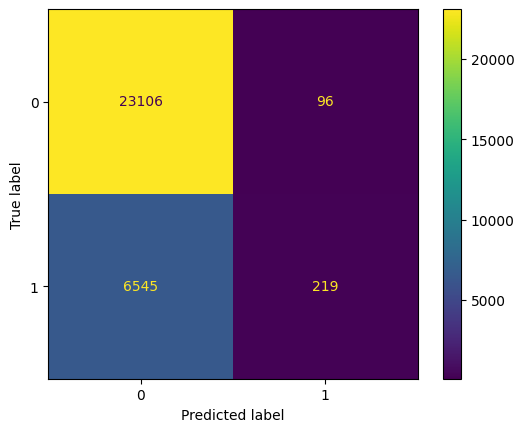

In [124]:
cm = confusion_matrix(y_test_qtr, predictions, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)

disp.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>